# Computing the path length in an object

This tutorial show you how to compute the path length for 3 objects (here from STL files). 

![3D objects](screenshot.png)

We store the parameters of the scanning geometry using a JSON file (`param.json`):

```json
{
  "WindowSize": [512, 512],
  "Source": {
    "Position": [-40.0,  0.0, 0.0, "cm"],
    "Shape": "ParallelBeam"
  },

  "Detector": {
    "Position": [40.0, 0.0, 0.0, "cm"],
    "UpVector": [0, 0, -1],
    "NumberOfPixels": [641, 320],
    "Spacing": [0.25, 0.25, "mm"]
  },

  "Samples": [
    {
      "Label": "cubes",
      "Path": "cubes.stl",
      "Unit": "mm"
    },

    {
      "Label": "gVXR",
      "Path": "gVXR.stl",
      "Unit": "mm"
    },

    {
      "Label": "spheres",
      "Path": "spheres.stl",
      "Unit": "mm"
    }
  ]
}
```

## Import packages

In [1]:
import json # Load the JSON file
import numpy as np # To save the image in ASCII
import SimpleITK as sitk # To save the image in a binary (optional)

import matplotlib.pyplot as plt # For plotting (optional)

import gvxrPython3 as gvxr # Simulate X-ray images

## Load the JSON file

In [2]:
with open('config.json') as f:
  params = json.load(f)

## Create an OpenGL context

In [3]:
gvxr.createWindow(0, 1, "EGL");

window_size = params["WindowSize"];
gvxr.setWindowSize(
    window_size[0],
    window_size[1]
);

## Set up the beam

In [4]:
source_position = params["Source"]["Position"];
gvxr.setSourcePosition(
    source_position[0],
    source_position[1],
    source_position[2],
    source_position[3]
);

source_shape = params["Source"]["Shape"]

if source_shape == "ParallelBeam":
    gvxr.useParallelBeam();
elif source_shape == "PointSource":
    gvxr.usePointSource();
else:
    raise "Unknown source shape:" + source_shape;

## Set up the detector

In [5]:
detector_position = params["Detector"]["Position"];
gvxr.setDetectorPosition(
    detector_position[0],
    detector_position[1],
    detector_position[2],
    detector_position[3]
);

detector_up = params["Detector"]["UpVector"];
gvxr.setDetectorUpVector(
    detector_up[0],
    detector_up[1],
    detector_up[2]
);

detector_number_of_pixels = params["Detector"]["NumberOfPixels"];
gvxr.setDetectorNumberOfPixels(
    detector_number_of_pixels[0],
    detector_number_of_pixels[1]
);

pixel_spacing = params["Detector"]["Spacing"];
gvxr.setDetectorPixelSize(
    pixel_spacing[0],
    pixel_spacing[1],
    pixel_spacing[2]
);

## Load the polygon meshes

In [6]:
for mesh in params["Samples"]:

    gvxr.loadMeshFile(
        mesh["Label"],
        mesh["Path"],
        mesh["Unit"]
    );

    gvxr.addPolygonMeshAsInnerSurface(mesh["Label"]);

## Dummy beam spectrum

In [7]:
gvxr.addEnergyBinToSpectrum(1,"keV",10); # 10 photons of 1 keV

## Compute the path length for every object

In [8]:
path_length = {};
for mesh in params["Samples"]:
    path_length[mesh["Label"]] = gvxr.computeLBuffer(mesh["Label"]);

## Save the path length using Numpy

In [9]:
for key in path_length:
    np.savetxt(key + "_path_length.txt", path_length[key]);

## Save the path length using SITK

In [10]:
for key in path_length:
    volume = sitk.GetImageFromArray(path_length[key]);
    volume.SetSpacing([pixel_spacing[0], pixel_spacing[1]]);
    sitk.WriteImage(volume, key + "_path_length.mha", useCompression=True);

## Display the path length using Matplotlib

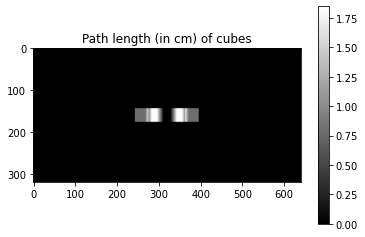

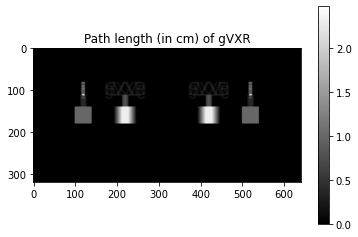

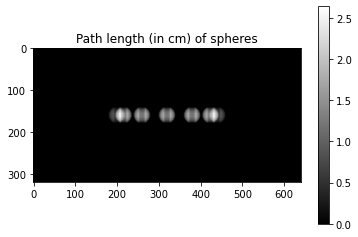

In [11]:
for key in path_length:
    fig=plt.figure();
    imgplot = plt.imshow(path_length[key], cmap="gray");
    plt.title("Path length (in cm) of " + key);
    plt.colorbar();
    plt.savefig(key + "_path_length.pdf");